### Cell A — Setup & Config (paths, knobs, seeding)

clip_len=32 / stride=2: good temporal coverage without blowing VRAM.

r3d18_k400: strong pretrained baseline; we’ll fine-tune.

staged unfreeze: learn head → then gently unfreeze layer4 to reduce overfitting/instability.

AMP: speedup + memory savings; using the correct torch.amp.autocast('cuda') API.

In [3]:
# === Cell A — Config / Paths / Globals (v2: larger subsets + aug/ema/clipping) ===
from pathlib import Path
import yaml, json, os
from datetime import datetime

# --- project root & src on sys.path (if you need your modules) ---
root = Path("..").resolve()                 # notebook sits at repo root
CONFIG_YAML = root / "configs" / "wlasl.yaml"  # generic name; optional

# --- load your existing yaml (optional; we still set overrides below) ---
CFG = yaml.safe_load(open(CONFIG_YAML, "r")) if CONFIG_YAML.exists() else {}

# Choose the dataset size here. We assume you have prebuilt manifests:
#  - data/wlasl_preprocessed/manifest_nslt100.csv
#  - data/wlasl_preprocessed/manifest_wlasl300.csv
#  - data/wlasl_preprocessed/manifest_wlasl1000.csv
DATASET_SIZE = CFG.get("dataset_size", "wlasl300")  # ['nslt100','wlasl300','wlasl1000']

_manifest_map = {
    "nslt100":   "data/wlasl_preprocessed/manifest_nslt100.csv",
    "wlasl300":  "data/wlasl_preprocessed/manifest_wlasl300.csv",
    "wlasl1000": "data/wlasl_preprocessed/manifest_wlasl1000.csv",
}
_manifest_rel = _manifest_map.get(DATASET_SIZE, _manifest_map["wlasl300"])

# --- core run configuration (overrides are explicit here) ---
CONFIG = {
    # data
    "dataset_size": DATASET_SIZE,          # tracked in run tag
    "manifest": _manifest_rel,
    "clip_len": 32,                        # temporal length per clip
    "frame_stride": 2,                     # per-frame step
    "batch_size": 8,
    "num_workers": 4,
    "use_weighted_sampler": True,          # class rebalancing
    "normalize": "kinetics",               # ['kinetics','none']

    # ✅ augmentation knobs (applied in Data cell):
    # safe for sign language (NO horizontal flip)
    "aug": {
        "random_resized_crop_scale": [0.7, 1.0],   # spatial crop scale range
        "color_jitter": [0.2, 0.2, 0.2, 0.05],     # brightness, contrast, saturation, hue
        "gaussian_noise_std": 0.01,                # mild sensor noise
        "random_erasing_p": 0.15,                  # small patch erase
        "temporal_jitter": True,                   # random start offset within segment
        "temporal_shuffle_small": True,            # tiny local shuffle (keeps semantics)
        "spatial_smooth_blur_p": 0.10,             # occasional light blur
    },

    # model & training
    "backbone": "r3d18_k400",              # ['r3d18_k400','c3dlite_gn']
    "dropout": 0.2,
    "label_smoothing": 0.05,               # a touch can help with larger sets
    "epochs": 30,                          # a little longer for bigger data
    "warmup_epochs": 2,

    # staged LR (head -> partial backbone)
    "lr_head_stage1": 1e-3,                # head-only stage
    "lr_back_stage1": 0.0,
    "lr_head_stage2": 1e-4,                # unfreeze last block
    "lr_back_stage2": 1e-5,

    "weight_decay": 1e-5,
    "cosine_eta_min": 1e-5,

    # extras that improve stability
    "amp": True,                           # mixed precision
    "compile": True,                       # torch.compile if available
    "freeze_backbone": True,
    "unfreeze_at_epoch": 5,
    "unfreeze_scope": "layer4",
    "grad_clip_norm": 1.0,                 # gradient clipping
    "ema": True,                           # Exponential Moving Average of weights
    "ema_decay": 0.999,

    # optional regularizers (wired later; keep off by default)
    "mixup_alpha": 0.0,                    # 0 disables
    "cutmix_alpha": 0.0,                   # 0 disables

    # checkpoints / runs
    "checkpoints_dir": "checkpoints",
    "runs_dir": "runs",

    # reproducibility
    "seed": 42,
}

# derived paths
MANIFEST = root / CONFIG["manifest"]
CKPT_DIR = root / CONFIG["checkpoints_dir"]
RUNS_DIR = root / CONFIG["runs_dir"]
CKPT_DIR.mkdir(parents=True, exist_ok=True)
RUNS_DIR.mkdir(parents=True, exist_ok=True)

# run tag (deterministic name for files)
run_tag = (
    f"{CONFIG['dataset_size']}_{CONFIG['backbone']}"
    f"_T{CONFIG['clip_len']}_S{CONFIG['frame_stride']}_B{CONFIG['batch_size']}_"
    f"{datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}"
)

# persist run config for traceability
with open(RUNS_DIR / f"{run_tag}.config.json", "w") as f:
    json.dump(CONFIG, f, indent=2)

print("root:", root)
print("manifest:", MANIFEST)
print("checkpoints:", CKPT_DIR)
print("runs:", RUNS_DIR)
print("run_tag:", run_tag)


root: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL
manifest: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/data/wlasl_preprocessed/manifest_wlasl300.csv
checkpoints: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/checkpoints
runs: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/runs
run_tag: wlasl300_r3d18_k400_T32_S2_B8_20251110T054150Z


In [4]:
CONFIG.update({
    "batch_size": 16,          # try 16; fall back to 8 + accum_steps=2 if OOM
    "accum_steps": 1,          # set to 2 if you keep batch_size=8
    "epochs": 50,              # more steps for 300 classes
    "mixup_alpha": 0.2,        # helps with many classes + few clips
    "cutmix_alpha": 0.0,       # keep off for sign
    "grad_clip_norm": 1.0,     # stability
    "ema": True,
    "ema_decay": 0.999,
    "lr_back_stage2": 3e-5,    # slightly faster backbone adaptation after unfreeze
    "warmup_epochs": 3,
})

Using manifest: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/data/wlasl_preprocessed/manifest_wlasl300.csv
Splits | train=1271 val=355 test=228 | classes=300


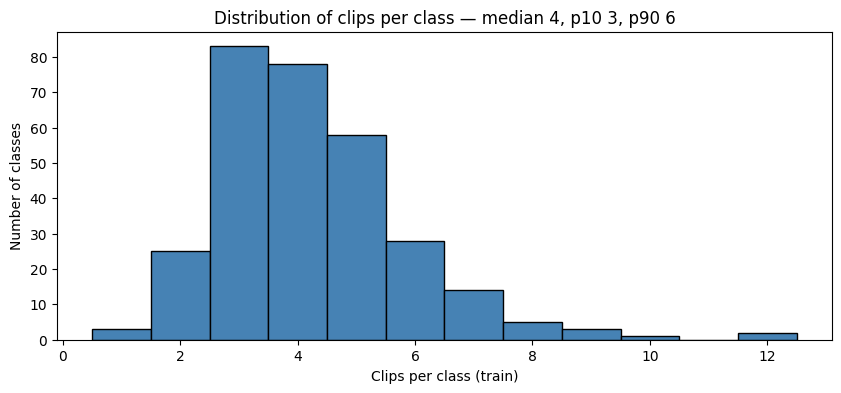


Top 10 classes by train samples:
 label      gloss  count
   164        bed     12
   168     before     12
   222    bowling     10
     8   accident      9
   154 basketball      9
   246    brother      9
   274       call      8
   196      black      8
   285      candy      8
    81      apple      8

Lowest 10 classes by train samples:
 label     gloss  count
   250       bug      1
   132         b      1
   213     boots      1
    27 advantage      2
    72   another      2
    99   article      2
   276     camel      2
   277    camera      2
   119   austria      2
   127     award      2

Showing samples from top 3 and bottom 3 classes...


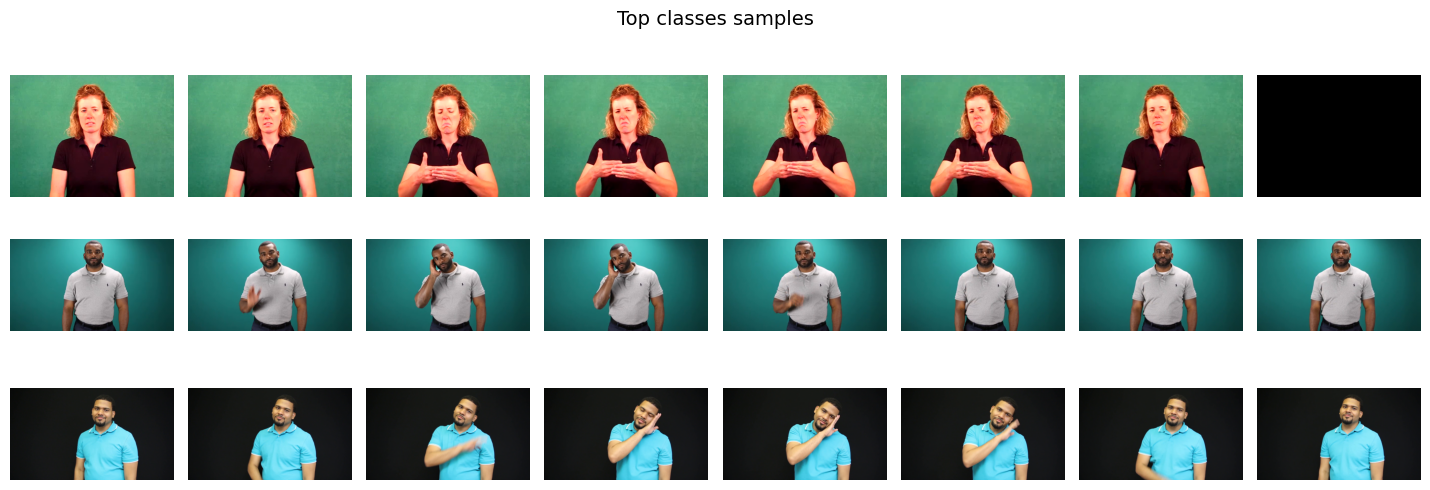

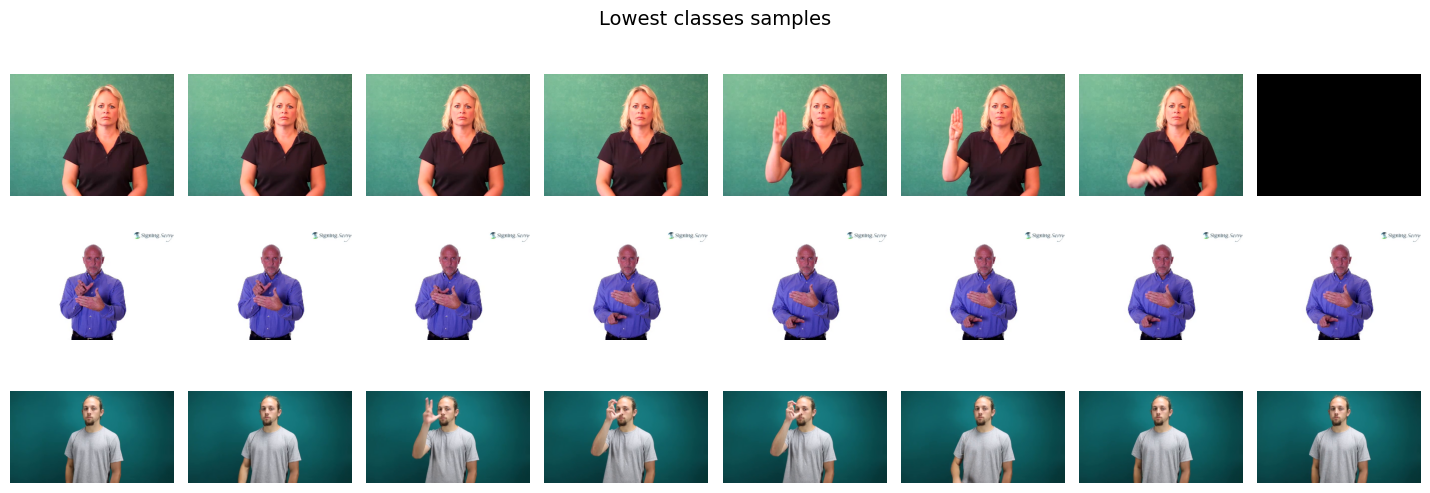


Average FPS ≈ 28.3, median resolution ≈ 3×656


In [6]:
# === Cell V0 — Data visualization & sample inspection ===
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from pathlib import Path
import random, math, torch

try:
    import decord
    decord.bridge.set_bridge("torch")
except Exception as e:
    print("⚠️ Decord not available:", e)
    decord = None

root = Path("..").resolve()
MANIFEST = root / CONFIG["manifest"]
print("Using manifest:", MANIFEST)

df = pd.read_csv(MANIFEST)
splits = {s: int((df["split"]==s).sum()) for s in ["train","val","test"]}
print(f"Splits | train={splits['train']} val={splits['val']} test={splits['test']} | classes={df['label'].nunique()}")

# -------------------------------
# 1️⃣ Distribution histogram
# -------------------------------
train_counts = df[df.split=="train"].groupby(["label","gloss"])["path"].count().reset_index(name="count")
n = train_counts["count"].to_numpy()
fig, ax = plt.subplots(figsize=(10,4))
ax.hist(n, bins=np.arange(0.5, n.max()+1.5, 1), color="steelblue", edgecolor="k")
ax.set_xlabel("Clips per class (train)")
ax.set_ylabel("Number of classes")
ax.set_title(f"Distribution of clips per class — median {np.median(n):.0f}, p10 {np.percentile(n,10):.0f}, p90 {np.percentile(n,90):.0f}")
plt.show()

# -------------------------------
# 2️⃣ Top & bottom 10 classes
# -------------------------------
top10 = train_counts.sort_values("count", ascending=False).head(10)
low10 = train_counts.sort_values("count", ascending=True).head(10)

print("\nTop 10 classes by train samples:")
print(top10.to_string(index=False))
print("\nLowest 10 classes by train samples:")
print(low10.to_string(index=False))

# -------------------------------
# 3️⃣ Video inspection helper
# -------------------------------
def _to_hwc(frame):
    """
    Accepts a single frame as torch.Tensor or np.ndarray.
    Returns np.ndarray in HWC (uint8 if possible).
    """
    import numpy as np, torch
    if isinstance(frame, torch.Tensor):
        arr = frame
        if arr.dtype.is_floating_point:  # decord often returns uint8 already
            arr = (arr * 255).clamp(0,255).to(torch.uint8)
        if arr.ndim == 3:
            # Heuristics: pick where the channel is
            if arr.shape[-1] == 3:        # HWC
                arr = arr
            elif arr.shape[0] == 3:       # CHW -> HWC
                arr = arr.permute(1,2,0).contiguous()
            elif arr.shape[1] == 3:       # H C W -> H W C (rare)
                arr = arr.permute(0,2,1).contiguous()
            else:
                # fallback: assume CHW
                arr = arr.permute(1,2,0).contiguous()
            return arr.cpu().numpy()
        else:
            return arr.cpu().numpy()
    else:
        # numpy array
        arr = frame
        if arr.ndim == 3:
            if arr.shape[-1] == 3:        # HWC
                return arr
            elif arr.shape[0] == 3:       # CHW -> HWC
                return np.transpose(arr, (1,2,0))
            elif arr.shape[1] == 3:       # H C W -> H W C
                return np.transpose(arr, (0,2,1))
        return arr

def show_video_grid(df_subset, title="", n_samples=3, frames_to_show=8):
    if decord is None or df_subset.empty:
        print("Decord not available or no samples to show.")
        return
    sample_paths = df_subset.sample(min(n_samples, len(df_subset)), random_state=0)["path"].tolist()
    rows = len(sample_paths); cols = frames_to_show
    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.8, rows*1.8))
    if rows == 1: axes = np.array([axes])
    fig.suptitle(title, fontsize=14)
    for i, rel_path in enumerate(sample_paths):
        p = root / rel_path
        try:
            vr = decord.VideoReader(str(p))
            total = len(vr)
            if total == 0:
                raise RuntimeError("zero frames")
            idxs = np.linspace(0, total-1, frames_to_show, dtype=int)
            batch = vr.get_batch(idxs)  # shape: [T, H, W, C] or [T, C, H, W]
            # iterate frames and plot
            for j in range(frames_to_show):
                f = batch[j]
                f_hwc = _to_hwc(f)
                ax = axes[i, j]
                ax.imshow(f_hwc)
                ax.axis("off")
            axes[i,0].set_ylabel(p.stem, fontsize=8)
        except Exception as e:
            print(f"⚠️ Failed to read {p.name} :", e)
    plt.tight_layout()
    plt.show()


# -------------------------------
# 4️⃣ Visualize examples
# -------------------------------
print("\nShowing samples from top 3 and bottom 3 classes...")
for subset, name in [(top10, "Top classes"), (low10, "Lowest classes")]:
    ex_df = df[df["gloss"].isin(subset["gloss"])]
    show_video_grid(ex_df, title=f"{name} samples", n_samples=3, frames_to_show=8)

# -------------------------------
# 5️⃣ Optional: global FPS / resolution summary
# -------------------------------
def probe_meta(path: Path):
    try:
        vr = decord.VideoReader(str(path))
        h,w = vr[0].shape[1:]
        return {"fps": vr.get_avg_fps(), "h":h, "w":w}
    except Exception:
        return {"fps": None, "h":None, "w":None}

sampled = df.sample(min(300, len(df)), random_state=1)
meta = []
for p_rel in sampled["path"]:
    meta.append(probe_meta(root / p_rel))
meta = pd.DataFrame(meta)
fps_mean = meta["fps"].dropna().mean()
size_median = meta[["h","w"]].median()
print(f"\nAverage FPS ≈ {fps_mean:.1f}, median resolution ≈ {int(size_median['w'])}×{int(size_median['h'])}")


In [3]:
### Cell B0 manifest builder

In [4]:
from pathlib import Path
print("Current notebook dir:", Path.cwd())
print("root =", Path("..").resolve())
print("exists:", (Path("..").resolve() / "data" / "wlasl_preprocessed" / "nslt_300.json").exists())


Current notebook dir: /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL/notebooks
root = /home/falasoul/notebooks/USD/AAI-590/Capstone/AAI-590-G3-ASL
exists: True


In [6]:
# === Cell B0 — Build larger WLASL manifests (300 / 1000) from WLASL_v0.3.json ===
from pathlib import Path
import json, re
import pandas as pd

root = Path("..").resolve()
droot = root / "data" / "wlasl_preprocessed"
videos_dir = droot / "videos"

# Inputs we actually have
wlasl_json = droot / "WLASL_v0.3.json"   # canonical annotations file
json_300   = droot / "nslt_300.json"     # optional: to select top-300 glosses
json_1000  = droot / "nslt_1000.json"    # optional: to select top-1000 glosses

# Outputs
out_300    = droot / "manifest_wlasl300.csv"
out_1000   = droot / "manifest_wlasl1000.csv"

def _load_json(path: Path):
    with open(path, "r") as f:
        return json.load(f)

def _list_glosses_from_subset(path: Path):
    """
    Returns a set of gloss names from nslt_*.json, regardless of whether it’s a list or dict-style file.
    """
    if not path.exists():
        return None
    data = _load_json(path)
    glosses = set()

    if isinstance(data, list):
        # common format: list of {"gloss": "...", "instances": [...]}
        for item in data:
            g = item.get("gloss") or item.get("label") or item.get("category")
            if g:
                glosses.add(str(g))
    elif isinstance(data, dict):
        # sometimes: {"database": { "<id>": {"gloss": "...", ...}, ...}}
        if "database" in data and isinstance(data["database"], dict):
            for _, v in data["database"].items():
                g = v.get("gloss") or v.get("label") or v.get("category")
                if g:
                    glosses.add(str(g))
        else:
            # fallback: any top-level dict entries with "gloss"
            for _, v in data.items():
                if isinstance(v, dict):
                    g = v.get("gloss") or v.get("label") or v.get("category")
                    if g:
                        glosses.add(str(g))
    return glosses if glosses else None

def _std_split_name(x):
    if x is None:
        return None
    s = str(x).lower()
    if s.startswith("train"):
        return "train"
    if s.startswith("val") or s in ("dev", "validation"):
        return "val"
    if s.startswith("test"):
        return "test"
    return None

def _video_path_for_id(vid: str):
    """
    Try common filename patterns inside videos_dir for a given video_id.
    """
    # clean id
    v = str(vid).split("/")[-1]
    v = re.sub(r"\.mp4$", "", v, flags=re.I)
    v = re.sub(r"[^A-Za-z0-9_\-]", "", v)

    candidates = [
        videos_dir / f"{v}.mp4",
        videos_dir / f"{v}.MP4",
    ]
    for p in candidates:
        if p.exists():
            return p

    # glob fallback (case-insensitive-ish via two patterns)
    hits = list(videos_dir.glob(f"*{v}*.mp4")) + list(videos_dir.glob(f"*{v}*.MP4"))
    return hits[0] if hits else None

def _build_from_wlasl_json(limit_glosses: set | None, out_csv: Path):
    if not wlasl_json.exists():
        raise FileNotFoundError(f"Missing {wlasl_json}")

    data = _load_json(wlasl_json)
    if not isinstance(data, list):
        raise ValueError(f"Unexpected schema in {wlasl_json.name}: expected a list of items.")

    rows = []
    missing_videos = []

    for item in data:
        gloss = item.get("gloss") or item.get("label") or item.get("category")
        if not gloss:
            continue
        if limit_glosses is not None and gloss not in limit_glosses:
            continue

        instances = item.get("instances") or item.get("clips") or []
        for ins in instances:
            split = _std_split_name(ins.get("subset") or ins.get("split") or ins.get("set"))
            if not split:
                continue

            # video id can be under different keys; WLASL v0.3 uses 'video_id'
            vid = ins.get("video_id") or ins.get("id") or ins.get("name") or ins.get("url") or ins.get("path")
            if not vid:
                continue

            p = _video_path_for_id(vid)
            if p is None:
                missing_videos.append(str(vid))
                continue

            rows.append({
                "path": str(p.relative_to(root)),
                "gloss": str(gloss),
                "split": split,
            })

    if not rows:
        raise RuntimeError("No rows produced. Check that your videos/ names match the IDs in WLASL_v0.3.json.")

    df = pd.DataFrame(rows)

    # Map gloss -> label 0..C-1 (sorted for determinism)
    glosses = sorted(df["gloss"].unique())
    g2id = {g:i for i,g in enumerate(glosses)}
    df["label"] = df["gloss"].map(g2id).astype(int)

    # Reorder to schema: path, gloss, label, split
    df = df[["path","gloss","label","split"]]

    # Drop rows whose file disappeared (safety)
    df = df[df["path"].map(lambda p: (root / p).exists())].reset_index(drop=True)

    # Basic stats
    n_train = (df["split"]=="train").sum()
    n_val   = (df["split"]=="val").sum()
    n_test  = (df["split"]=="test").sum()
    n_cls   = df["label"].nunique()

    print(f"[{out_csv.name}]  Splits | train={n_train}  val={n_val}  test={n_test}  | classes={n_cls}")
    if len(df):
        print(f"  Example: {df.iloc[0]['path']}  gloss={df.iloc[0]['gloss']}  label={df.iloc[0]['label']}")

    # Save manifest
    df.to_csv(out_csv, index=False)

    # Save a small report of missing videos
    miss_path = out_csv.with_suffix(".missing_video_ids.txt")
    if missing_videos:
        with open(miss_path, "w") as f:
            for v in sorted(set(missing_videos)):
                f.write(str(v) + "\n")
        print(f"  Note: {len(set(missing_videos))} video ids not found in {videos_dir.name}. Logged to {miss_path.name}.")
    else:
        if miss_path.exists():
            miss_path.unlink()

    return df

# ---- Build 300 ----
gloss300 = _list_glosses_from_subset(json_300)
if gloss300 is None:
    print("⚠️ nslt_300.json not found or ambiguous; will approximate 300 classes by taking the first 300 glosses present in WLASL_v0.3.json after file matching.")
    # Build full → then clip to 300 classes deterministically
    full_tmp = droot / "_manifest_tmp_full.csv"
    df_full = _build_from_wlasl_json(limit_glosses=None, out_csv=full_tmp)
    keep = sorted(df_full["gloss"].unique())[:300]
    df_300 = df_full[df_full["gloss"].isin(keep)].reset_index(drop=True)
    # remap labels 0..C-1 for this subset
    glosses = sorted(df_300["gloss"].unique())
    g2id = {g:i for i,g in enumerate(glosses)}
    df_300["label"] = df_300["gloss"].map(g2id).astype(int)
    df_300 = df_300[["path","gloss","label","split"]]
    df_300.to_csv(out_300, index=False)
    if full_tmp.exists(): full_tmp.unlink()
    print(f"[{out_300.name}]  Splits | train={(df_300['split']=='train').sum()}  val={(df_300['split']=='val').sum()}  test={(df_300['split']=='test').sum()}  | classes={df_300['label'].nunique()}")
else:
    _build_from_wlasl_json(limit_glosses=gloss300, out_csv=out_300)

# ---- Build 1000 ----
gloss1000 = _list_glosses_from_subset(json_1000)
if gloss1000 is None:
    print("⚠️ nslt_1000.json not found or ambiguous; approximating 1000 classes similarly.")
    # Build full → then clip to 1000 classes deterministically
    full_tmp = droot / "_manifest_tmp_full.csv"
    df_full = _build_from_wlasl_json(limit_glosses=None, out_csv=full_tmp)
    keep = sorted(df_full["gloss"].unique())[:1000]
    df_1000 = df_full[df_full["gloss"].isin(keep)].reset_index(drop=True)
    glosses = sorted(df_1000["gloss"].unique())
    g2id = {g:i for i,g in enumerate(glosses)}
    df_1000["label"] = df_1000["gloss"].map(g2id).astype(int)
    df_1000 = df_1000[["path","gloss","label","split"]]
    df_1000.to_csv(out_1000, index=False)
    if full_tmp.exists(): full_tmp.unlink()
    print(f"[{out_1000.name}]  Splits | train={(df_1000['split']=='train').sum()}  val={(df_1000['split']=='val').sum()}  test={(df_1000['split']=='test').sum()}  | classes={df_1000['label'].nunique()}")
else:
    _build_from_wlasl_json(limit_glosses=gloss1000, out_csv=out_1000)

print("Done.")


⚠️ nslt_300.json not found or ambiguous; will approximate 300 classes by taking the first 300 glosses present in WLASL_v0.3.json after file matching.
[_manifest_tmp_full.csv]  Splits | train=8313  val=2253  test=1414  | classes=2000
  Example: data/wlasl_preprocessed/videos/69241.mp4  gloss=book  label=210
  Note: 9103 video ids not found in videos. Logged to _manifest_tmp_full.missing_video_ids.txt.
[manifest_wlasl300.csv]  Splits | train=1271  val=355  test=228  | classes=300
⚠️ nslt_1000.json not found or ambiguous; approximating 1000 classes similarly.
[_manifest_tmp_full.csv]  Splits | train=8313  val=2253  test=1414  | classes=2000
  Example: data/wlasl_preprocessed/videos/69241.mp4  gloss=book  label=210
  Note: 9103 video ids not found in videos. Logged to _manifest_tmp_full.missing_video_ids.txt.
[manifest_wlasl1000.csv]  Splits | train=4205  val=1136  test=734  | classes=1000
Done.


### Cell B — Data Loader (self-contained, robust)
A tiny inline Dataset avoids surprises from older src.data.* code.

We normalize like Kinetics (what r3d_18 expects).

We skip missing/corrupt paths up front

In [7]:
# === Cell B — Data loader (video-safe augmentation; manifest-driven) ===
import pandas as pd
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch, random

# ---- seed everything ----
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True
seed_everything(CONFIG["seed"])

# ---- try decord first (faster); fallback to torchvision.io ----
USE_DECORD = False
try:
    import decord
    # ✅ ensure FFmpeg messages are suppressed
    import logging, os
    logging.getLogger("decord").setLevel(logging.ERROR)
    os.environ["DECORD_LOG_LEVEL"] = "ERROR"
    os.environ["FFMPEG_LOG_LEVEL"] = "error"

    # ✅ set torch bridge (so frames come as torch tensors)
    decord.bridge.set_bridge('torch')

    USE_DECORD = True
    print("Decord active ✅")
except Exception as e:
    print("⚠️ Decord unavailable, using torchvision.io. Reason:", e)
    from torchvision.io import read_video
    USE_DECORD = False

# ---------- Video I/O ----------
def _read_raw_video(path):
    """
    Returns frames as torch.uint8 [T, H, W, C] (range 0..255) if possible,
    else returns an empty tensor.
    """
    if USE_DECORD:
        try:
            vr = decord.VideoReader(path)
            total = len(vr)
            if total == 0:
                return torch.empty(0, dtype=torch.uint8)
            frames = vr.get_batch(range(total)).byte()  # [T,H,W,C], uint8
            return frames
        except Exception:
            return torch.empty(0, dtype=torch.uint8)
    else:
        try:
            v, _, _ = read_video(path, pts_unit="sec")  # [T,H,W,C], uint8
            return v.to(torch.uint8)
        except Exception:
            return torch.empty(0, dtype=torch.uint8)

# ---------- Normalization ----------
def kinetics_normalize(x):
    # x [T,C,H,W] float32 in [0,1]
    mean = torch.tensor((0.432,0.394,0.376), dtype=x.dtype, device=x.device)[None,:,None,None]
    std  = torch.tensor((0.228,0.221,0.223), dtype=x.dtype, device=x.device)[None,:,None,None]
    return (x - mean) / std

# ---------- Spatial ops (consistent across frames) ----------
import torchvision.transforms.functional as TF
import torch.nn.functional as F

def _param_random_resized_crop(h, w, scale):
    """
    Returns parameters for a consistent RandomResizedCrop across frames.
    """
    # Try a few times to sample a valid crop; otherwise fallback to center
    for _ in range(10):
        target_area = random.uniform(*scale) * (h * w)
        aspect = random.uniform(3/4, 4/3)
        nh = int(round((target_area * aspect) ** 0.5))
        nw = int(round((target_area / aspect) ** 0.5))
        if 0 < nh <= h and 0 < nw <= w:
            top = random.randint(0, h - nh) if h - nh > 0 else 0
            left = random.randint(0, w - nw) if w - nw > 0 else 0
            return top, left, nh, nw
    # fallback: center crop (as large as possible)
    short = min(h, w)
    top = (h - short) // 2
    left = (w - short) // 2
    return top, left, short, short

def _apply_consistent_spatial(x_TCHW, out_hw=(112,112), aug_cfg=None, train=True):
    """
    x_TCHW: float32 [T,C,H,W] in [0,1]
    Applies spatial transforms consistently across T.
    """
    Tt, C, H, W = x_TCHW.shape
    out_h, out_w = out_hw

    if train and aug_cfg is not None:
        # 1) RandomResizedCrop (consistent)
        scale = tuple(aug_cfg.get("random_resized_crop_scale", [1.0, 1.0]))
        top, left, hh, ww = _param_random_resized_crop(H, W, scale)
        x_TCHW = x_TCHW[:, :, top:top+hh, left:left+ww]
        # 2) Resize to model resolution
        x_TCHW = F.interpolate(x_TCHW, size=(out_h, out_w), mode="bilinear", align_corners=False)

        # 3) Color jitter — single set of params for whole clip
        # brightness, contrast, saturation, hue
        bj, cj, sj, hj = aug_cfg.get("color_jitter", [0.0, 0.0, 0.0, 0.0])
        if any(v > 0 for v in [bj, cj, sj, hj]):
            b = 1.0 + random.uniform(-bj, bj)
            c = 1.0 + random.uniform(-cj, cj)
            s = 1.0 + random.uniform(-sj, sj)
            h = random.uniform(-hj, hj)
            # Apply to each frame (consistent params)
            x_TCHW = torch.stack([TF.adjust_hue(
                                      TF.adjust_saturation(
                                          TF.adjust_contrast(
                                              TF.adjust_brightness(x_TCHW[t], b), c),
                                          s),
                                      h)
                                  for t in range(Tt)], dim=0)

        # 4) Occasional slight blur (helps sensor variance)
        if random.random() < aug_cfg.get("spatial_smooth_blur_p", 0.0):
            # 3x3 gaussian-like box blur
            kernel = torch.tensor([[1,2,1],[2,4,2],[1,2,1]], dtype=x_TCHW.dtype, device=x_TCHW.device)
            kernel = kernel / kernel.sum()
            kernel = kernel.view(1,1,3,3)
            # depthwise per-channel conv
            x_TCHW = F.conv2d(x_TCHW.reshape(Tt*C,1,out_h,out_w), kernel, padding=1).reshape(Tt,C,out_h,out_w)

        # 5) Random erasing on a random frame (small patch)
        if random.random() < aug_cfg.get("random_erasing_p", 0.0):
            t = random.randrange(Tt)
            area = out_h * out_w
            erase_area = random.uniform(0.02, 0.1) * area
            aspect = random.uniform(0.3, 3.3)
            eh = int(round((erase_area * aspect) ** 0.5))
            ew = int(round((erase_area / aspect) ** 0.5))
            if eh < out_h and ew < out_w:
                ty = random.randint(0, out_h - eh)
                tx = random.randint(0, out_w - ew)
                x_TCHW[t, :, ty:ty+eh, tx:tx+ew] = 0.0

    else:
        # eval path: center crop then resize
        short = min(H, W)
        top = (H - short) // 2
        left = (W - short) // 2
        x_TCHW = x_TCHW[:, :, top:top+short, left:left+short]
        x_TCHW = F.interpolate(x_TCHW, size=(out_h, out_w), mode="bilinear", align_corners=False)

    return x_TCHW

# ---------- Temporal ops ----------
def _sample_indices(total, Treq, stride, temporal_jitter=True):
    """
    Returns frame indices length Treq with given stride; loops if short.
    If temporal_jitter: randomize starting offset within feasible window.
    """
    if total <= 0:
        return np.zeros(Treq, dtype=np.int64)

    span = (Treq - 1) * stride + 1
    if total >= span:
        max_start = total - span
        start = random.randint(0, max_start) if temporal_jitter else max_start // 2
        idxs = start + np.arange(0, Treq * stride, stride)
    else:
        # loop if too short
        base = np.arange(0, Treq * stride, stride) % total
        if temporal_jitter and total > 1:
            jitter = random.randint(0, total-1)
            base = (base + jitter) % total
        idxs = base
    return idxs.astype(np.int64)

def _tiny_temporal_shuffle(idxs, prob=0.15):
    """
    Small local shuffle: with given prob, swap a few adjacent positions.
    Preserves global order cues while adding robustness.
    """
    idxs = idxs.copy()
    if prob <= 0: 
        return idxs
    Tn = len(idxs)
    for i in range(Tn - 1):
        if random.random() < prob * 0.15:  # keep very mild
            idxs[i], idxs[i+1] = idxs[i+1], idxs[i]
    return idxs

# ---------- Clip reader w/ augmentation ----------
def read_clip(path, clip_len, stride, size=(112,112), train=False, aug_cfg=None, normalize="kinetics"):
    """
    Returns a Tensor [T, C, H, W] in float32.
    - Samples T=clip_len frames with step=stride (+temporal jitter if train).
    - Applies consistent spatial aug across frames (train only).
    - Optional tiny temporal shuffle (train only).
    - Kinetics normalization (by default).
    """
    raw = _read_raw_video(path)  # [T,H,W,C] uint8
    if raw.numel() == 0:
        # fallback: blank clip
        x = torch.zeros(clip_len, 3, size[0], size[1], dtype=torch.float32)
        return x

    total = raw.shape[0]
    tids = _sample_indices(total, clip_len, stride, temporal_jitter=train and aug_cfg.get("temporal_jitter", True))
    if train and aug_cfg.get("temporal_shuffle_small", True):
        tids = _tiny_temporal_shuffle(tids, prob=0.15)

    # gather frames, to float [0,1] and permute to T,C,H,W
    frames = raw[tids].float() / 255.0           # [T,H,W,C] -> float
    frames = frames.permute(0,3,1,2).contiguous()# -> [T,C,H,W]

    # consistent spatial aug + resize
    frames = _apply_consistent_spatial(frames, out_hw=size, aug_cfg=aug_cfg, train=train)

    # mild gaussian noise (train only)
    if train and aug_cfg.get("gaussian_noise_std", 0.0) > 0:
        std = aug_cfg["gaussian_noise_std"]
        noise = torch.randn_like(frames) * std
        frames = torch.clamp(frames + noise, 0.0, 1.0)

    # normalize
    if normalize == "kinetics":
        frames = kinetics_normalize(frames)

    return frames  # [T,C,H,W]

# ---------- Dataset ----------
class WLASLFromManifest(Dataset):
    """
    Dataset reading WLASL manifest with columns: path|video_path, gloss, label, split
    Returns: X [T,C,H,W], y (int), meta (dict)
    """
    def __init__(self, df, clip_len=32, stride=2, train=False, normalize="kinetics", aug_cfg=None):
        self.df = df.reset_index(drop=True).copy()
        self.clip_len = clip_len
        self.stride = stride
        self.train = train
        self.normalize = normalize
        self.aug_cfg = aug_cfg or {}

    def __len__(self): 
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        p = row.get("path", row.get("video_path"))
        x = read_clip(
            p, 
            self.clip_len, 
            self.stride, 
            size=(112,112), 
            train=self.train, 
            aug_cfg=self.aug_cfg if self.train else {},
            normalize=self.normalize
        )
        y = int(row["label"])
        return x, torch.tensor(y, dtype=torch.long), {"path": p}

# ---------- Read manifest & harmonize paths ----------
m = pd.read_csv(MANIFEST)
if "video_path" in m.columns and "path" not in m.columns:
    m = m.rename(columns={"video_path": "path"})
m["path"]  = m["path"].apply(lambda p: str((root / p).resolve()))
m["label"] = m["label"].astype(int)

# drop missing to avoid reader errors
exists_mask = m["path"].map(lambda p: Path(p).exists())
missing = (~exists_mask).sum()
if missing:
    print(f"[Data] Skipping {missing} missing/corrupt videos.")
    m = m[exists_mask].reset_index(drop=True)

# splits
train_df = m[m.split=="train"].reset_index(drop=True)
val_df   = m[m.split=="val"].reset_index(drop=True)
test_df  = m[m.split=="test"].reset_index(drop=True)
num_classes = m["label"].nunique()

# datasets (train uses augmentation)
train_ds = WLASLFromManifest(
    train_df,
    clip_len=CONFIG["clip_len"],
    stride=CONFIG["frame_stride"],
    train=True,
    normalize=CONFIG["normalize"],
    aug_cfg=CONFIG.get("aug", {})
)
val_ds   = WLASLFromManifest(
    val_df,
    clip_len=CONFIG["clip_len"],
    stride=CONFIG["frame_stride"],
    train=False,
    normalize=CONFIG["normalize"]
)
test_ds  = WLASLFromManifest(
    test_df,
    clip_len=CONFIG["clip_len"],
    stride=CONFIG["frame_stride"],
    train=False,
    normalize=CONFIG["normalize"]
)

# loaders
bs, nw = CONFIG["batch_size"], CONFIG["num_workers"]
if CONFIG["use_weighted_sampler"]:
    counts  = train_df["label"].value_counts().to_dict()
    weights = train_df["label"].map(lambda y: 1.0 / counts[y]).values.astype("float32")
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    train_loader = DataLoader(train_ds, batch_size=bs, sampler=sampler, num_workers=nw, pin_memory=True)
else:
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=nw, pin_memory=True)

val_loader  = DataLoader(val_ds,  batch_size=bs, shuffle=False, num_workers=nw, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=bs, shuffle=False, num_workers=nw, pin_memory=True)

print(f"Splits | train={len(train_ds)} val={len(val_ds)} test={len(test_ds)} | classes={num_classes}")

# quick sanity batch
xb, yb, mb = next(iter(train_loader))
print("train batch:", xb.shape, yb[:min(8,len(yb))].tolist())


Decord active ✅
Splits | train=1271 val=355 test=228 | classes=300


[h264 @ 0x596a6d980200] Invalid NAL unit size (71678 > 10776).
[h264 @ 0x596a6d980200] Error splitting the input into NAL units.


train batch: torch.Size([16, 32, 3, 112, 112]) [148, 294, 247, 278, 161, 235, 203, 198]


### Cell C — Training (staged unfreeze, AMP fixed)

In [ ]:
# === Cell C — Training (EMA + grad clipping + optional mixup/cutmix) ===
import torch, torch.nn as nn, numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import GradScaler, autocast

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ---- model ----
from torchvision.models.video import r3d_18, R3D_18_Weights

if CONFIG["backbone"] == "r3d18_k400":
    weights = R3D_18_Weights.KINETICS400_V1
    model = r3d_18(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
else:
    class C3DliteGN(nn.Module):
        def __init__(self, num_classes=100, drop=0.5):
            super().__init__()
            def gn(c): return nn.GroupNorm(num_groups=8, num_channels=c)
            def block(cin, cout, pool_t=2):
                return nn.Sequential(
                    nn.Conv3d(cin, cout, 3, padding=1, bias=False),
                    gn(cout), nn.ReLU(inplace=True),
                    nn.MaxPool3d(kernel_size=(pool_t,2,2), stride=(pool_t,2,2))
                )
            self.stem = nn.Sequential(nn.Conv3d(3,32,3,padding=1,bias=False), gn(32), nn.ReLU(inplace=True))
            self.b1 = block(32,  64); self.b2 = block(64, 128)
            self.b3 = block(128, 256); self.b4 = block(256, 256)
            self.head = nn.Sequential(nn.AdaptiveAvgPool3d(1), nn.Flatten(),
                                      nn.Dropout(CONFIG["dropout"]), nn.Linear(256, num_classes))
        def forward(self, x):              # x: [B,T,C,H,W]
            x = x.permute(0,2,1,3,4).contiguous()  # -> [B,C,T,H,W]
            x = self.stem(x); x = self.b1(x); x = self.b2(x); x = self.b3(x); x = self.b4(x)
            return self.head(x)
    model = C3DliteGN(num_classes=num_classes, drop=CONFIG["dropout"])

model.to(device)
EXPECTS_BCTHW = (CONFIG["backbone"] == "r3d18_k400")

# ---- freezing (stage 1: head only) ----
def set_frozen(module, frozen=True):
    for p in module.parameters():
        p.requires_grad = not frozen

if CONFIG["freeze_backbone"]:
    set_frozen(model, True)
    if hasattr(model, "fc"): set_frozen(model.fc, False)
    scope = CONFIG["unfreeze_scope"]
    if hasattr(model, scope): set_frozen(getattr(model, scope), True)

# ---- criterion / optim / sched / scaler ----
criterion = nn.CrossEntropyLoss(label_smoothing=CONFIG["label_smoothing"])

head_params = list(model.fc.parameters()) if hasattr(model, "fc") else []
head_ids = {id(p) for p in head_params}
backbone_params = [p for p in model.parameters() if id(p) not in head_ids]

optimizer = optim.AdamW(
    [{"params": head_params, "lr": CONFIG["lr_head_stage1"]},
     {"params": backbone_params, "lr": CONFIG["lr_back_stage1"]}],
    weight_decay=CONFIG["weight_decay"],
)

scheduler = CosineAnnealingLR(
    optimizer,
    T_max=max(1, CONFIG["epochs"] - CONFIG["warmup_epochs"]),
    eta_min=CONFIG["cosine_eta_min"],
)

scaler = GradScaler(enabled=CONFIG["amp"])

# Optional compile
if CONFIG.get("compile", True) and hasattr(torch, "compile"):
    try:
        model = torch.compile(model)
        print("torch.compile: ON")
    except Exception as e:
        print("torch.compile skipped:", str(e))

# ---- EMA ----
class ModelEMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {}
        m = model._orig_mod if hasattr(model, "_orig_mod") else model
        for name, p in m.named_parameters():
            if p.requires_grad:
                self.shadow[name] = p.detach().clone()

    @torch.no_grad()
    def update(self, model):
        m = model._orig_mod if hasattr(model, "_orig_mod") else model
        for name, p in m.named_parameters():
            if not p.requires_grad: continue
            s = self.shadow.get(name)
            if s is None: self.shadow[name] = p.detach().clone()
            else: s.mul_(self.decay).add_(p.detach(), alpha=1.0 - self.decay)

    def store(self, model):
        m = model._orig_mod if hasattr(model, "_orig_mod") else model
        self.backup = {name: p.detach().clone() for name, p in m.named_parameters()}

    @torch.no_grad()
    def copy_to(self, model):
        m = model._orig_mod if hasattr(model, "_orig_mod") else model
        for name, p in m.named_parameters():
            if name in self.shadow:
                p.data.copy_(self.shadow[name].data)

    def restore(self, model):
        m = model._orig_mod if hasattr(model, "_orig_mod") else model
        for name, p in m.named_parameters():
            p.data.copy_(self.backup[name].data)

ema = ModelEMA(model, decay=CONFIG.get("ema_decay", 0.999)) if CONFIG.get("ema", True) else None

# ---- Mixup / Cutmix (off unless alphas > 0) ----
mixup_alpha  = float(CONFIG.get("mixup_alpha", 0.0))
cutmix_alpha = float(CONFIG.get("cutmix_alpha", 0.0))

def rand_bbox(W, H, lam):
    cut_w = int(W * (1 - lam) ** 0.5)
    cut_h = int(H * (1 - lam) ** 0.5)
    cx = np.random.randint(W); cy = np.random.randint(H)
    x1 = np.clip(cx - cut_w // 2, 0, W); y1 = np.clip(cy - cut_h // 2, 0, H)
    x2 = np.clip(cx + cut_w // 2, 0, W); y2 = np.clip(cy + cut_h // 2, 0, H)
    return x1, y1, x2, y2

def apply_mix(x, y):
    has_mixup  = mixup_alpha  > 0.0
    has_cutmix = cutmix_alpha > 0.0
    if not (has_mixup or has_cutmix):
        return x, y, y, 1.0, "none"
    mode = "mixup" if (has_mixup and (not has_cutmix or np.random.rand() < 0.5)) else "cutmix"
    if mode == "mixup":
        lam = np.random.beta(mixup_alpha, mixup_alpha)
        perm = torch.randperm(x.size(0), device=x.device)
        x = lam * x + (1 - lam) * x[perm]
        return x, y, y[perm], lam, "mixup"
    else:
        lam = np.random.beta(cutmix_alpha, cutmix_alpha)
        B, T, C, H, W = x.shape
        perm = torch.randperm(B, device=x.device); x_perm = x[perm]
        x1, y1, x2, y2 = rand_bbox(W, H, lam)
        x[:, :, :, y1:y2, x1:x2] = x_perm[:, :, :, y1:y2, x1:x2]
        lam = 1.0 - ((x2 - x1) * (y2 - y1) / (W * H))
        return x, y, y[perm], lam, "cutmix"

def compute_loss(logits, y, y_b=None, lam=1.0, mode="none"):
    if mode == "none": return criterion(logits, y)
    return lam * criterion(logits, y) + (1 - lam) * criterion(logits, y_b)

def warmup_lr(optim, epoch, warmup_epochs, base_head, base_back):
    if epoch < warmup_epochs:
        s = float(epoch + 1) / max(1, warmup_epochs)
        optim.param_groups[0]["lr"] = base_head * s
        optim.param_groups[1]["lr"] = base_back * s
        return True
    return False

def run_one_epoch(loader, train=True):
    model.train(train)
    total_loss = total_acc = total_n = 0
    for xb, yb, _ in loader:
        xb = xb.to(device, non_blocking=True)   # [B,T,C,H,W]
        yb = yb.to(device, non_blocking=True)

        if train:
            xb, y_a, y_b, lam, mode = apply_mix(xb, yb)
        else:
            y_a, y_b, lam, mode = yb, yb, 1.0, "none"

        if EXPECTS_BCTHW:
            xb_in = xb.permute(0,2,1,3,4).contiguous()
        else:
            xb_in = xb

        if train: optimizer.zero_grad(set_to_none=True)
        with autocast("cuda", enabled=CONFIG["amp"]):
            logits = model(xb_in)
            loss = compute_loss(logits, y_a, y_b=y_b, lam=lam, mode=mode)

        if train:
            scaler.scale(loss).backward()
            if CONFIG.get("grad_clip_norm", 0) > 0:
                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), CONFIG["grad_clip_norm"])
            scaler.step(optimizer)
            scaler.update()
            if ema is not None: ema.update(model)

        bs = yb.size(0)
        total_n += bs
        total_loss += loss.item() * bs
        total_acc  += (logits.argmax(1) == y_a).float().sum().item()

    return total_loss / max(1,total_n), total_acc / max(1,total_n)

best_val = -1.0
best_path = CKPT_DIR / "best.pt"
last_path = CKPT_DIR / "last.pt"

print(f"Start training for {CONFIG['epochs']} epochs on {device} | run: {run_tag}")

for epoch in range(CONFIG["epochs"]):
    warmed = warmup_lr(
        optimizer, epoch, CONFIG["warmup_epochs"],
        CONFIG["lr_head_stage1"], CONFIG["lr_back_stage1"]
    )
    if not warmed:
        scheduler.step()

    if CONFIG["freeze_backbone"] and epoch == CONFIG["unfreeze_at_epoch"]:
        scope = CONFIG["unfreeze_scope"]
        if hasattr(model, scope):
            print(f"Unfreezing {scope} at epoch {epoch}")
            set_frozen(getattr(model, scope), False)
        optimizer.param_groups[0]["lr"] = CONFIG["lr_head_stage2"]
        optimizer.param_groups[1]["lr"] = CONFIG["lr_back_stage2"]

    tr_loss, tr_acc = run_one_epoch(train_loader, train=True)

    # validate under EMA weights if enabled
    if ema is not None:
        ema.store(model); ema.copy_to(model)
    va_loss, va_acc = run_one_epoch(val_loader, train=False)
    if ema is not None:
        ema.restore(model)

    print(f"Epoch {epoch+1:03d}/{CONFIG['epochs']} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.3f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.3f}")

    # save last + best (save EMA snapshot if enabled)
    to_save = model
    if ema is not None:
        ema.store(model); ema.copy_to(model); to_save = model

    unwrapped = to_save._orig_mod if hasattr(to_save, "_orig_mod") else to_save
    state = {
        "model": unwrapped.state_dict(),
        "epoch": epoch,
        "val_acc": va_acc,
        "config": CONFIG,
        "run_tag": run_tag,
        "num_classes": num_classes,
    }
    torch.save(state, last_path)
    if va_acc > best_val:
        best_val = va_acc
        torch.save(state, best_path)

    if ema is not None:
        ema.restore(model)

print(f"[DONE] Best val acc: {best_val:.3f} | saved to {best_path}")


#### Cell D — Sanity & Throughput Diagnostics.

In [ ]:
# === Cell D0 — Sanity & Throughput Diagnostics ===
from pathlib import Path
import pandas as pd, numpy as np, time, math, threading, subprocess, shutil, sys, os

root = Path("..").resolve()
MANIFEST = root / CONFIG["manifest"]

print("Manifest:", MANIFEST)
df = pd.read_csv(MANIFEST)

# -------------------------------
# 1) DATA HEALTH & BALANCE
# -------------------------------
def split_counts(df):
    return {s: int((df["split"]==s).sum()) for s in ["train","val","test"]}

sc = split_counts(df)
n_cls = df["label"].nunique()
print(f"Splits | train={sc['train']} val={sc['val']} test={sc['test']} | classes={n_cls}")

# Per-class train counts
train_counts = (df[df.split=="train"]
                .groupby(["label","gloss"], as_index=False)
                .size().rename(columns={"size":"n"}))
if not len(train_counts):
    raise RuntimeError("No train rows found in manifest; cannot analyze.")

# Summary stats
n = train_counts["n"].to_numpy()
print("\n[Train per-class counts]")
print(f"min={n.min()}  p10={np.percentile(n,10):.1f}  median={np.median(n):.1f}  p90={np.percentile(n,90):.1f}  max={n.max()}")

low_mask = train_counts["n"] < 3
few = train_counts[low_mask].sort_values("n")
print(f"Classes with <3 train clips: {len(few)}/{n_cls}")
print(few.head(10).to_string(index=False))

# Save a CSV report (full histogram & low-sample classes)
out_dir = root / "runs"
out_dir.mkdir(parents=True, exist_ok=True)
perclass_csv = out_dir / f"{run_tag}.train_per_class_counts.csv"
low_csv      = out_dir / f"{run_tag}.low_sample_classes_lt3.csv"
train_counts.sort_values("n").to_csv(perclass_csv, index=False)
few.to_csv(low_csv, index=False)
print(f"\nSaved:\n- {perclass_csv}\n- {low_csv}")

# -------------------------------
# 2) VIDEO INTEGRITY CHECK
# -------------------------------
# Try opening a sample of videos with Decord; read a tiny indexed batch.
bad = []
tested = 0

try:
    import decord
    decord.bridge.set_bridge('torch')
    # sample up to this many across splits to keep it quick
    SAMPLE_MAX = 400
    # prefer train+val since they impact learning curves
    df_check = pd.concat([
        df[df.split=="train"].sample(min(SAMPLE_MAX//2, (df.split=="train").sum()), random_state=0),
        df[df.split=="val"].sample(min(SAMPLE_MAX//3, (df.split=="val").sum()), random_state=1),
        df[df.split=="test"].sample(min(SAMPLE_MAX//6, (df.split=="test").sum()), random_state=2),
    ], ignore_index=True).drop_duplicates(subset=["path"])

    for p in df_check["path"]:
        vp = root / p
        try:
            vr = decord.VideoReader(str(vp))
            total = len(vr)
            if total == 0:
                raise RuntimeError("zero frames")
            # probe a few sparse frames
            idxs = np.unique(np.clip(np.array([0, total//3, 2*total//3, total-1]), 0, max(total-1,0))).astype(int)
            _ = vr.get_batch(idxs)
        except Exception as e:
            bad.append({"path": str(p), "error": type(e).__name__ + ": " + str(e)})
        tested += 1

    bad_df = pd.DataFrame(bad)
    bad_path = out_dir / f"{run_tag}.bad_videos_sample.csv"
    if len(bad_df):
        bad_df.to_csv(bad_path, index=False)
        print(f"\n[Video health] Tested {tested} files | Bad: {len(bad_df)} (sample). Logged to {bad_path}")
        print(bad_df.head(8).to_string(index=False))
    else:
        print(f"\n[Video health] Tested {tested} files | No decode errors in sample ✅")

except Exception as e:
    print("\n[Video health] Skipped (Decord not available or failed to init).", e)

# -------------------------------
# 3) THROUGHPUT & GPU UTILIZATION
# -------------------------------
# We’ll poll nvidia-smi while running a short forward-only loop.
def gpu_util_samples(duration_s=10, interval_s=0.5):
    samples = []
    if shutil.which("nvidia-smi") is None:
        return samples
    end = time.time() + duration_s
    while time.time() < end:
        try:
            out = subprocess.check_output(
                ["nvidia-smi", "--query-gpu=utilization.gpu", "--format=csv,noheader,nounits"],
                stderr=subprocess.DEVNULL
            ).decode().strip().splitlines()
            # if multiple GPUs, take the one with CUDA_VISIBLE_DEVICES=0 implicitly
            util = int(out[0])
            samples.append(util)
        except Exception:
            pass
        time.sleep(interval_s)
    return samples

# Short benchmark: data time vs compute time
import torch
from torch.amp import autocast

have_model = "model" in globals()
if not have_model:
    print("\n[GPU load] Note: model not found in globals(). Will only time the dataloader.")
    model = None

iters = min(60, len(train_loader))  # short probe
data_times, compute_times = [], []

# Start background GPU poller
UTIL_DURATION = 12
UTIL_INTERVAL = 0.4
utils = []
stop_flag = False

def poller():
    nonlocal utils, stop_flag
    while not stop_flag:
        s = gpu_util_samples(duration_s=UTIL_INTERVAL, interval_s=UTIL_INTERVAL)
        if len(s): utils.extend(s)

thr = threading.Thread(target=poller, daemon=True)
thr.start()

# Run a quick forward-only loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if have_model:
    model.eval()

with torch.no_grad():
    for i, (xb, yb, _) in enumerate(train_loader):
        t0 = time.time()
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        t1 = time.time()

        if have_model:
            if CONFIG["backbone"] == "r3d18_k400":
                xb_in = xb.permute(0,2,1,3,4).contiguous()
            else:
                xb_in = xb
            with autocast("cuda", enabled=CONFIG.get("amp", True)):
                _ = model(xb_in)
        t2 = time.time()

        data_times.append(t1 - t0)
        compute_times.append(max(0.0, t2 - t1))
        if i+1 >= iters:
            break

# Stop poller
stop_flag = True
thr.join(timeout=1.0)

def pct(x, q): 
    return np.percentile(x, q) if len(x) else float("nan")

print("\n[Throughput timing over", len(data_times), "iters]")
print(f"Data time (sec/iter):  mean={np.mean(data_times):.3f}  p50={pct(data_times,50):.3f}  p90={pct(data_times,90):.3f}")
if have_model:
    print(f"Compute time (sec/iter): mean={np.mean(compute_times):.3f}  p50={pct(compute_times,50):.3f}  p90={pct(compute_times,90):.3f}")

if len(utils):
    print(f"\n[GPU utilization samples] n={len(utils)}  mean={np.mean(utils):.1f}%  p50={pct(utils,50):.1f}%  p90={pct(utils,90):.1f}%  max={np.max(utils):.0f}%")
else:
    print("\n[GPU utilization] nvidia-smi not found or no samples gathered.")

print("\nDone.")


In [ ]:
# === Cell D1 — Clean manifest: drop decode-bad files & classes with <3 train clips ===
from pathlib import Path
import pandas as pd

root = Path("..").resolve()
man_in  = root / CONFIG["manifest"]  # current wlasl300
runs_dir = root / "runs"
bad_csv  = max(runs_dir.glob(f"{run_tag}.bad_videos_sample.csv"), default=None)
man_out  = man_in.with_name("manifest_wlasl300_clean.csv")

df = pd.read_csv(man_in)

# 1) Drop known-bad video paths (from the Decord probe)
if bad_csv and bad_csv.exists():
    bad = pd.read_csv(bad_csv)["path"].astype(str).tolist()
    before = len(df)
    df = df[~df["path"].isin(bad)].reset_index(drop=True)
    print(f"Dropped decode-bad files: {before - len(df)}")
else:
    print("No bad-video CSV found; skipping file drops.")

# 2) Prune classes with <3 train clips (only affects 'train' rows; keep val/test of remaining classes)
train = df[df.split=="train"]
counts = train.groupby("label")["path"].count()
keep_labels = set(counts[counts >= 3].index.tolist())
print(f"Keeping {len(keep_labels)} classes with >=3 train clips; dropping {df['label'].nunique() - len(keep_labels)} low-sample classes.")

df = df[df["label"].isin(keep_labels)].reset_index(drop=True)

# 3) Re-map labels to 0..C-1 (deterministic, by gloss sort)
glosses = sorted(df["gloss"].unique())
g2id = {g:i for i,g in enumerate(glosses)}
df["label"] = df["gloss"].map(g2id).astype(int)

df = df[["path","gloss","label","split"]]
df.to_csv(man_out, index=False)

# Stats
sc = {s: int((df["split"]==s).sum()) for s in ["train","val","test"]}
print(f"[{man_out.name}] Splits | train={sc['train']} val={sc['val']} test={sc['test']} | classes={df['label'].nunique()}")
print("Example:", df.iloc[0].to_dict())


In [ ]:
# === Cell D2 — GPU/Data timing probe ===
import time, subprocess, shutil, numpy as np, torch
from torch.amp import autocast

def gpu_util_once():
    if shutil.which("nvidia-smi") is None:
        return None
    try:
        out = subprocess.check_output(
            ["nvidia-smi","--query-gpu=utilization.gpu","--format=csv,noheader,nounits"],
            stderr=subprocess.DEVNULL
        ).decode().strip().splitlines()
        return int(out[0])
    except Exception:
        return None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
have_model = "model" in globals()
if have_model: model.eval()

iters = min(40, len(train_loader))
data_t, comp_t, utils = [], [], []

with torch.no_grad():
    for i, (xb, yb, _) in enumerate(train_loader):
        t0 = time.time()
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        t1 = time.time()

        if have_model:
            if CONFIG["backbone"] == "r3d18_k400":
                xb_in = xb.permute(0,2,1,3,4).contiguous()
            else:
                xb_in = xb
            with autocast("cuda", enabled=CONFIG.get("amp", True)):
                _ = model(xb_in)
        t2 = time.time()

        data_t.append(t1 - t0)
        comp_t.append(max(0.0, t2 - t1))
        u = gpu_util_once()
        if u is not None: utils.append(u)

        if i+1 >= iters: break

def pct(x,q): return np.percentile(x,q) if len(x) else float("nan")

print(f"Data time (s/iter):   mean={np.mean(data_t):.3f}  p50={pct(data_t,50):.3f}  p90={pct(data_t,90):.3f}")
print(f"Compute time (s/iter): mean={np.mean(comp_t):.3f}  p50={pct(comp_t,50):.3f}  p90={pct(comp_t,90):.3f}")
if utils:
    print(f"GPU util (%):          mean={np.mean(utils):.1f}  p50={pct(utils,50):.1f}  p90={pct(utils,90):.1f}  max={np.max(utils):.0f}")
else:
    print("GPU util: nvidia-smi unavailable or no samples.")
